In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(98765)

In [2]:
# bsm data set
data = pd.read_csv('data/cod.csv')

col_names = data.columns
data = data.to_numpy()

# bsm
# 1 Qin ; 5 Ssi ; 7 XBH2 ;8 SNO2 ;25 SO5
covariate_col = ['1', '5', '7','25']
response_col = '30' # COD

X = data[:,np.where([t in covariate_col for t in col_names])[0]]
Y = data[:,np.where(col_names==response_col)[0]].flatten()
X = X.astype('float64')
Y = Y.astype('float64')

N = X.shape[0]
train_lag = 500 # start predicting after train_lag many observations

In [3]:
%%script false

data = pd.read_csv('data/electricity-normalized.csv')
col_names = data.columns
data = data.to_numpy()

# remove the first stretch of time where 'transfer' does not vary
data = data[17760:]

# set up variables for the task (predicting 'transfer')
covariate_col = ['nswprice', 'nswdemand', 'vicprice', 'vicdemand']
response_col = 'transfer'
# keep data points for 9:00am - 12:00pm
keep_rows = np.where((data[:,2]>data[17,2])&(data[:,2]<data[24,2]))[0]

X = data[keep_rows][:,np.where([t in covariate_col for t in col_names])[0]]
Y = data[keep_rows][:,np.where(col_names==response_col)[0]].flatten()
X = X.astype('float64')[:1500, :]
Y = Y.astype('float64')[:1500]

N = X.shape[0]
train_lag = 500  # start predicting after train_lag many observations

Couldn't find program: 'false'


In [4]:
# run all methods
from models.cp import cqr, aecp, aecp_aci, secp, secp_aci, adaSecp, adaSecp_aci, calculate_wis

methods = np.array([
    "cqr",
    "aecp",
    "secp",
    "adaSecp",
    "aecp_aci",
    "secp_aci",
    "adaSecp_aci",
])

# Initialize alpha and erro
PI_SCP = {method: np.zeros((N, 2)) for method in methods}
alpha_t = {method: np.zeros((N+1-train_lag)) for method in methods}
erro_t = {method: np.zeros((N+1-train_lag)) for method in methods}

p_rf = np.zeros((N))
alphas = [0.4, 0.3, 0.2, 0.1, 0.05, 0.01]

# conformal_methods
def train_conformal_methods(n, X_train, Y_train, X_test, Y_test, alpha_val=0.2):
    results = {}
    results['PI_cqr'] = cqr(X_train, Y_train, X_test, alpha_val)
    results['PI_aecp'], p_rf[n] = aecp(X_train, Y_train, X_test, alpha_val)
    results['PI_secp'], p_rf[n] = secp(X_train, Y_train, X_test, alpha_val)
    results['PI_adaSecp'], p_rf[n] = adaSecp(X_train, Y_train, X_test, alpha_val)
    results['PI_aecp_aci'], alpha_t['aecp_aci'][count+1], erro_t['aecp_aci'][count] = aecp_aci(count, X_train, Y_train, X_test, Y_test, alpha_val, alpha_t['aecp_aci'][count], erro_t['aecp_aci'], gamma=0.01)
    results['PI_secp_aci'], alpha_t['secp_aci'][count+1], erro_t['secp_aci'][count] = secp_aci(count, X_train, Y_train, X_test, Y_test, alpha_val, alpha_t['secp_aci'][count], erro_t['secp_aci'], gamma=0.01)
    results['PI_adaSecp_aci'], alpha_t['adaSecp_aci'][count+1], erro_t['adaSecp_aci'][count], p_rf[n] = adaSecp_aci(
        count, X_train, Y_train, X_test, Y_test, alpha_val, alpha_t['adaSecp_aci'][count], erro_t['adaSecp_aci'], lamda=10, window_size_k=5, gamma=0.1) # λ, k, γ 
    
    return results

# Initializes the result dictionary
results = {alpha: {method: {} for method in methods} for alpha in alphas}

for alpha_val in alphas:
    print(f"Running for alpha = {alpha_val}")

    count = 0

    for n in np.arange(train_lag, N):

        X_train = X[(n-train_lag):n, :]
        Y_train = Y[(n-train_lag):n]
        X_test = X[n:(n+1)]
        Y_test = Y[n:(n+1)]

        # train
        method_results = train_conformal_methods(n, X_train, Y_train, X_test, Y_test, alpha_val)

        # save results
        for method in methods:
            PI_SCP[method][n, :] = method_results[f'PI_{method}']

        count += 1

    # caculate coverage, width, WIS
    for m in methods:
        pi_scp = PI_SCP[m]
        results[alpha_val][m]['PI_cov'] = (pi_scp[train_lag:, 0] <= Y[train_lag:]) & (pi_scp[train_lag:, 1] >= Y[train_lag:])
        results[alpha_val][m]['PI_width'] = pi_scp[train_lag:, 1] - pi_scp[train_lag:, 0]
        results[alpha_val][m]['PI_wis'] = calculate_wis(Y[train_lag:], pi_scp[train_lag:, 0], pi_scp[train_lag:, 1], alpha_val)



c:\ProgramData\Anaconda3\envs\py376_acr\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\ProgramData\Anaconda3\envs\py376_acr\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
c:\ProgramData\Anaconda3\envs\py376_acr\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding c

Running for alpha = 0.4
Running for alpha = 0.3
Running for alpha = 0.2
Running for alpha = 0.1
Running for alpha = 0.05
Running for alpha = 0.01


In [5]:
# print results
print("\nFinal Results for all alphas:")
print(['      ', 'coverage', 'mean width','mean wis'])

for alpha_val in alphas:
    print(f"\nResults for alpha = {alpha_val}:")
    for m in methods:
        coverage = np.mean(results[alpha_val][m]['PI_cov'])
        mean_width = np.mean(results[alpha_val][m]['PI_width'])
        mean_wis = results[alpha_val][m]['PI_wis']
        print([m, 
               f"{coverage:.3f}", 
               f"{mean_width:.3f}", 
               f"{mean_wis:.3f}"])


Final Results for all alphas:
['      ', 'coverage', 'mean width', 'mean wis']

Results for alpha = 0.4:
['cqr', '0.323', '1.080', '2.800']
['aecp', '0.297', '1.064', '2.771']
['secp', '0.440', '0.655', '1.609']
['adaSecp', '0.542', '0.745', '1.241']
['aecp_aci', '0.557', '1.556', '2.294']
['secp_aci', '0.588', '0.832', '1.405']
['adaSecp_aci', '0.595', '0.405', '0.746']

Results for alpha = 0.3:
['cqr', '0.448', '1.303', '3.028']
['aecp', '0.425', '1.269', '2.958']
['secp', '0.540', '0.783', '1.721']
['adaSecp', '0.655', '0.841', '1.371']
['aecp_aci', '0.840', '1.981', '2.328']
['secp_aci', '0.868', '1.299', '1.485']
['adaSecp_aci', '0.955', '1.418', '1.470']

Results for alpha = 0.2:
['cqr', '0.590', '1.559', '3.264']
['aecp', '0.583', '1.501', '3.143']
['secp', '0.682', '0.918', '1.870']
['adaSecp', '0.755', '0.962', '1.512']
['aecp_aci', '0.925', '2.136', '2.356']
['secp_aci', '0.938', '1.434', '1.555']
['adaSecp_aci', '0.963', '1.477', '1.541']

Results for alpha = 0.1:
['cqr', '

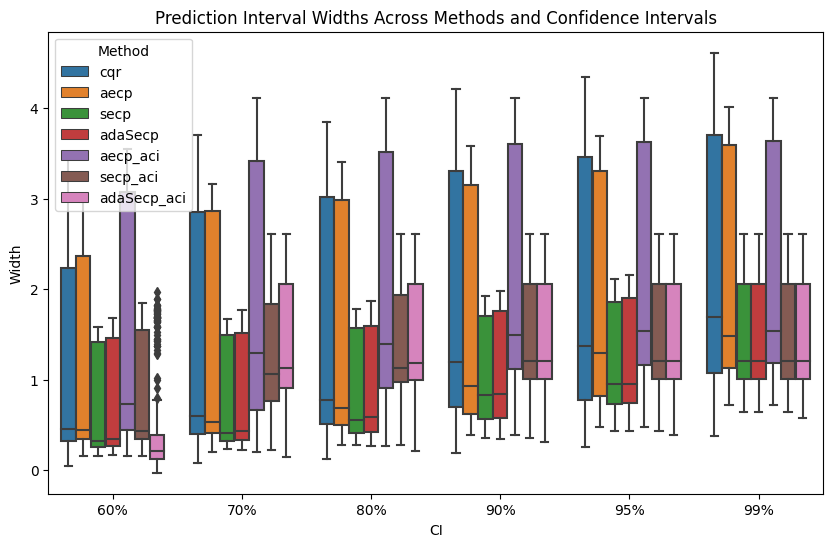

In [6]:
# box plot
import seaborn as sns
data_for_plot = {
    'Method': [],
    'Width': [],
    'CI': []
}

for alpha_val in alphas:
    for method in methods:
        widths = results[alpha_val][method]['PI_width']
        data_for_plot['Method'].extend([method] * len(widths))
        data_for_plot['Width'].extend(widths)
        data_for_plot['CI'].extend([f"{int((1-alpha_val) * 100)}%" for _ in range(len(widths))])

df_plot = pd.DataFrame(data_for_plot)

plt.figure(figsize=(10, 6))
sns.boxplot(x='CI', y='Width', hue='Method', data=df_plot)
plt.title('Prediction Interval Widths Across Methods and Confidence Intervals')
plt.ylabel('Width')
plt.xlabel('CI')
plt.savefig('./fig/pi_boxplot', dpi=500, bbox_inches='tight')
plt.show()